In [1]:
import logging
from os.path import expanduser
from pathlib import Path

from matplotlib import cm, colors, pyplot as plt
import pandas as pd
from scipy.spatial import Voronoi, voronoi_plot_2d
import seaborn as sns
import yaml

from fehm_toolkit.config import ModelConfig, PressureConfig
from fehm_toolkit.hydrostatic_pressure import compute_hydrostatic_pressure, _read_density_lookup
from fehm_toolkit.file_interface import read_grid, read_restart, read_pressure

In [2]:
%matplotlib inline

In [3]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s (%(levelname)s) %(message)s')

In [4]:
toolkit_dir = Path(expanduser('~/repos/fehmToolkit'))
DENSITY_LOOKUP = _read_density_lookup(toolkit_dir / 'test' / 'end_to_end' / 'fixtures' / 'nist120-1800.out')

# Assess similarity in explicit vs interpolated pressures

In [5]:
def compare_pressure_calculations(explicit_config, sampled_config, grid, state) -> pd.DataFrame:
    explicit_pressures = compute_hydrostatic_pressure(
        grid=grid,
        state=state,
        pressure_config=explicit_config,
        density_lookup_MPa_degC=DENSITY_LOOKUP,
    )
    sampled_pressures = compute_hydrostatic_pressure(
        grid=grid,
        state=state,
        pressure_config=sampled_config,
        density_lookup_MPa_degC=DENSITY_LOOKUP,
    )
    
    x, y, z, depth = {}, {}, {}, {}
    for node in grid.nodes:
        x[node.number] = node.x
        y[node.number] = node.y
        z[node.number] = node.z
        depth[node.number] = node.depth

    single_material_zone = {
        node_number: zone.number
        for zone in grid.material_zones
        for node_number in zone.data
    }
    single_outside_zone = {
        node_number: zone.name
        for zone in grid.outside_zones
        for node_number in zone.data
    }

    df = pd.DataFrame(data={
        'x': x,
        'y': y,
        'z': z,
        'depth': depth,
        'material_zone': single_material_zone,
        'outside_zone': single_outside_zone,
        'explicit_P': explicit_pressures,
        'sampled_P': sampled_pressures,
    })

    df['explicit_P'] = df.explicit_P * 1000 # kPa
    df['sampled_P'] = df.sampled_P * 1000 # kPa
    df['delta_P'] = df.sampled_P - df.explicit_P
    return df

## Flat box

In [6]:
flat_box_dir = toolkit_dir / 'test' / 'end_to_end' / 'fixtures' / 'flat_box' / 'cond'

flat_box_grid = read_grid(
    fehm_file=flat_box_dir / 'cond.fehm',
    outside_zone_file=flat_box_dir / 'cond_outside.zone',
    material_zone_file=flat_box_dir / 'cond_material.zone',
    read_elements=False,
)
flat_box_state, restart_metadata = read_restart(flat_box_dir / 'cond.fin')

In [7]:
flat_box = compare_pressure_calculations(
    explicit_config=PressureConfig(
        pressure_model=ModelConfig(kind='depth', params={
            'z_interval_m': 5,
            'reference_z': 4450,
            'reference_pressure_MPa': 25,
            'reference_temperature_degC': 2,        
        }),
        interpolation_model=ModelConfig(kind='none', params={}),
    ),
    sampled_config=PressureConfig(
        pressure_model=ModelConfig(kind='depth', params={
            'z_interval_m': 5,
            'reference_z': 4450,
            'reference_pressure_MPa': 25,
            'reference_temperature_degC': 2,        
        }),
        interpolation_model=ModelConfig(kind='regular_grid', params={
            'x_samples': 4,
            'y_samples': 4,
            'z_samples': 100,
        }),
        sampling_model=ModelConfig(kind='explicit_lists', params={
            'explicit_outside_zones': ['top'],
        }),
    ),
    grid=flat_box_grid,
    state=flat_box_state,
)

2022-07-06 15:35:19,901 (INFO) Generating temperature lookups
2022-07-06 15:35:19,903 (INFO) Calculating explicit pressures for 194/194 nodes
2022-07-06 15:35:20,363 (INFO) Pressures calculated: 194 / 194
2022-07-06 15:35:20,369 (INFO) Generating temperature lookups
2022-07-06 15:35:20,370 (INFO) Calculating explicit pressures for 9/194 nodes
2022-07-06 15:35:20,381 (INFO) Pressures calculated: 9 / 9
2022-07-06 15:35:20,384 (INFO) Sampling with spacing:
    x:     333.33
    y:     333.33
    z:      40.40
2022-07-06 15:35:20,385 (INFO) Calculating explicit pressures for 16 sampled columns.
2022-07-06 15:35:20,386 (INFO) Pressures calculated:   0%
2022-07-06 15:35:20,434 (INFO) Pressures calculated:  75%
2022-07-06 15:35:20,450 (INFO) Interpolating remaining node pressures


<AxesSubplot:>

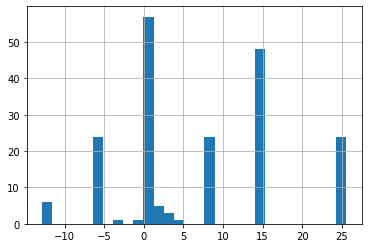

In [8]:
flat_box.delta_P.hist(bins=30)

# NP 2D

In [9]:
np_2d_dir = toolkit_dir / 'matlab_archive' / 'test' / 'fixtures' / 'np2d_cond'

np_2d_grid = read_grid(
    fehm_file=np_2d_dir / 'cond.fehm',
    outside_zone_file=np_2d_dir / 'cond_outside.zone',
    material_zone_file=np_2d_dir / 'cond_material.zone',
    read_elements=False,
)
np_2d_state, restart_metadata = read_restart(np_2d_dir / 'cond.fin')

In [10]:
np_2d = compare_pressure_calculations(
    explicit_config=PressureConfig(
        pressure_model=ModelConfig(kind='depth', params={
            'z_interval_m': 5,
            'reference_z': 4174.31,
            'reference_pressure_MPa': 45.289,
            'reference_temperature_degC': 2,
        }),
        interpolation_model=ModelConfig(kind='none', params={}),
    ),
    sampled_config=PressureConfig(
        pressure_model=ModelConfig(kind='depth', params={
            'z_interval_m': 5,
            'reference_z': 4174.31,
            'reference_pressure_MPa': 45.289,
            'reference_temperature_degC': 2,       
        }),
        interpolation_model=ModelConfig(kind='regular_grid', params={
            'x_samples': 100,
            'z_samples': 1000,
        }),
        sampling_model=ModelConfig(kind='explicit_lists', params={
            'explicit_outside_zones': ['top'],
        }),
    ),
    grid=np_2d_grid,
    state=np_2d_state,
)

2022-07-06 15:35:22,151 (INFO) Generating temperature lookups
2022-07-06 15:35:22,163 (INFO) Calculating explicit pressures for 35840/35840 nodes
2022-07-06 15:35:36,036 (INFO) Pressures calculated: 10000 / 35840
2022-07-06 15:35:50,089 (INFO) Pressures calculated: 20000 / 35840
2022-07-06 15:36:06,925 (INFO) Pressures calculated: 30000 / 35840
2022-07-06 15:36:17,763 (INFO) Pressures calculated: 35840 / 35840
2022-07-06 15:36:17,872 (INFO) Generating temperature lookups
2022-07-06 15:36:17,884 (INFO) Calculating explicit pressures for 1009/35840 nodes
2022-07-06 15:36:18,594 (INFO) Pressures calculated: 1009 / 1009
2022-07-06 15:36:18,597 (INFO) Sampling with spacing:
    x:     254.55
    z:       4.63
2022-07-06 15:36:18,598 (INFO) Calculating explicit pressures for 100 sampled columns.
2022-07-06 15:36:18,599 (INFO) Pressures calculated:   0%
2022-07-06 15:36:18,637 (INFO) Pressures calculated:  10%
2022-07-06 15:36:18,675 (INFO) Pressures calculated:  20%
2022-07-06 15:36:18,713 (

<AxesSubplot:>

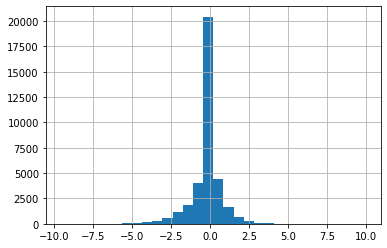

In [11]:
np_2d.delta_P.hist(bins=30)

# JdF 3D

In [12]:
jdf_3d_dir = toolkit_dir / 'matlab_archive' / 'test' / 'fixtures' / 'jdf3d_conduit_p12'

jdf_3d_grid = read_grid(
    fehm_file=jdf_3d_dir / 'p12.fehm',
    outside_zone_file=jdf_3d_dir / 'p12_outside.zone',
    material_zone_file=jdf_3d_dir / 'p12_material.zone',
    read_elements=False,
)
jdf_3d_state, restart_metadata = read_restart(jdf_3d_dir / 'cond.fin')

In [13]:
jdf_3d = compare_pressure_calculations(
    explicit_config=PressureConfig(
        pressure_model=ModelConfig(kind='depth', params={
            'z_interval_m': 5,
            'reference_z': 4450,
            'reference_pressure_MPa': 25,
            'reference_temperature_degC': 2,
        }),
        interpolation_model=ModelConfig(kind='none', params={}),
    ),
    sampled_config=PressureConfig(
        pressure_model=ModelConfig(kind='depth', params={
            'z_interval_m': 5,
            'reference_z': 4450,
            'reference_pressure_MPa': 25,
            'reference_temperature_degC': 2,     
        }),
        interpolation_model=ModelConfig(kind='regular_grid', params={
            'x_samples': 80,
            'y_samples': 160,
            'z_samples': 500,
        }),
        sampling_model=ModelConfig(kind='explicit_lists', params={
            'explicit_outside_zones': ['top'],
        }),
    ),
    grid=jdf_3d_grid,
    state=jdf_3d_state,
)

2022-07-06 15:36:27,987 (INFO) Generating temperature lookups
2022-07-06 15:36:28,130 (INFO) Calculating explicit pressures for 396508/396508 nodes
2022-07-06 15:36:41,354 (INFO) Pressures calculated: 10000 / 396508
2022-07-06 15:36:54,429 (INFO) Pressures calculated: 20000 / 396508
2022-07-06 15:37:08,303 (INFO) Pressures calculated: 30000 / 396508
2022-07-06 15:37:21,838 (INFO) Pressures calculated: 40000 / 396508
2022-07-06 15:37:37,404 (INFO) Pressures calculated: 50000 / 396508
2022-07-06 15:37:52,257 (INFO) Pressures calculated: 60000 / 396508
2022-07-06 15:38:06,825 (INFO) Pressures calculated: 70000 / 396508
2022-07-06 15:38:20,132 (INFO) Pressures calculated: 80000 / 396508
2022-07-06 15:38:34,090 (INFO) Pressures calculated: 90000 / 396508
2022-07-06 15:38:49,814 (INFO) Pressures calculated: 100000 / 396508
2022-07-06 15:39:02,970 (INFO) Pressures calculated: 110000 / 396508
2022-07-06 15:39:16,455 (INFO) Pressures calculated: 120000 / 396508
2022-07-06 15:39:31,598 (INFO) Pr

<AxesSubplot:>

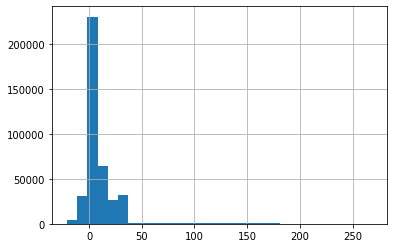

In [14]:
jdf_3d.delta_P.hist(bins=30)

<AxesSubplot:>

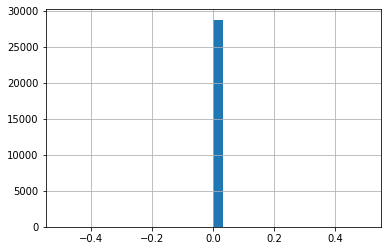

In [15]:
jdf_3d[jdf_3d.outside_zone == 'top'].delta_P.hist(bins=30)

<AxesSubplot:>

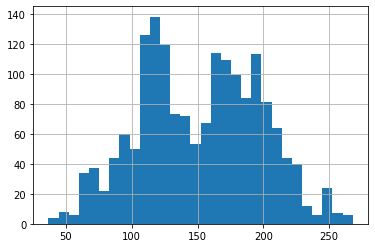

In [16]:
jdf_3d[jdf_3d.outside_zone == 'bottom'].delta_P.hist(bins=30)

<AxesSubplot:>

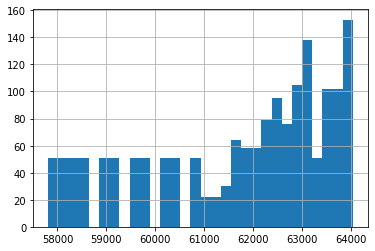

In [17]:
jdf_3d[jdf_3d.outside_zone == 'bottom'].explicit_P.hist(bins=30)

<AxesSubplot:xlabel='y', ylabel='explicit_P'>

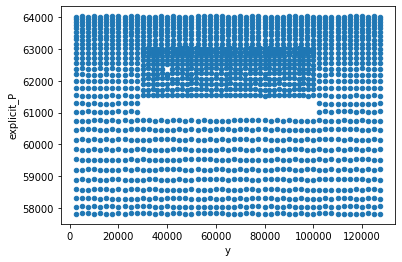

In [18]:
jdf_3d[jdf_3d.outside_zone == 'bottom'].plot(x='y', y='explicit_P', kind='scatter')

In [19]:
def plot_vornoi(plot_data: pd.DataFrame, plot_cols: list, value_col: str, aspect='equal'):
    vor = Voronoi((plot_data[plot_cols] / 1000).values)
    values = plot_data[value_col].values

    norm = colors.Normalize(vmin=min(values), vmax=max(values), clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.Reds)

    fig, ax = plt.subplots(figsize=(8, 8))
    voronoi_plot_2d(vor, show_points=False, show_vertices=False, line_width=0.3, ax=ax)
    for region_index, region_values in zip(vor.point_region, values):
        region = vor.regions[region_index]
        if -1 in region:
            continue

        polygon = [vor.vertices[i] for i in region]
        ax.fill(*zip(*polygon), color=mapper.to_rgba(region_values))

    if aspect is not None:
        ax.set_aspect(aspect)
    ax.set_xlabel(r'x ($km$)')
    ax.set_ylabel(r'y ($km$)')
    plt.colorbar(mapper, ax=ax)

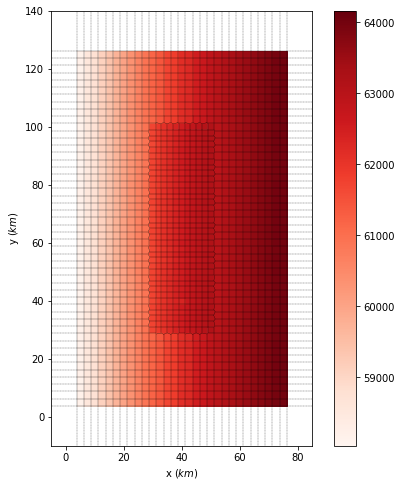

In [20]:
plot_vornoi(jdf_3d[jdf_3d.outside_zone == 'bottom'], ['x', 'y'], 'sampled_P')

In [21]:
jdf_3d.head()

,x,y,z,depth,material_zone,outside_zone,explicit_P,sampled_P,delta_P
1,42500.0,40500.0,4000.0,0.0,1,top,29470.96084,29470.96084,0.0
2,43000.0,40500.0,4000.0,0.0,1,top,29470.96084,29470.96084,0.0
3,43500.0,40500.0,4000.0,0.0,1,top,29470.96084,29470.96084,0.0
4,44000.0,40500.0,4000.0,0.0,1,top,29470.96084,29470.96084,0.0
5,44500.0,40500.0,4000.0,0.0,1,top,29470.96084,29470.96084,0.0
